# House price prediction

The purpose of this project is to predict sales prices for houses using regression techniques

## 1. Preprocessing

## 1.1. Load data, drop null values and duplicates

For now, all the columns with samples smaller than 1460 will be removed. It is possible to transform this values later.

In [32]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
##from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV

In [33]:
df= pd.read_csv('train.csv')
df.columns = df.columns.str.lower() 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [50]:
cat_th=10 
car_th=20
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
cat_cols = cat_cols + num_but_cat
cat_cols = [col for col in cat_cols if col not in cat_but_car]

# num_cols
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
num_cols = [col for col in num_cols if col not in num_but_cat]

print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f'cat_cols: {len(cat_cols)}')
print(f'num_cols: {len(num_cols)}')
print(f'cat_but_car: {len(cat_but_car)}')
print(f'num_but_cat: {len(num_but_cat)}')
    
print(f"""Categorical Variables={cat_cols},\nNumerical Variables={num_cols},\nCategorical but Cardinal Variables={cat_but_car}""")

Observations: 1460
Variables: 81
cat_cols: 53
num_cols: 26
cat_but_car: 2
num_but_cat: 11
Categorical Variables=['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'fireplaces', 'garagecars', 'poolarea', 'yrsold'],
Numerical Variables=['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmt

<function matplotlib.pyplot.show(close=None, block=None)>

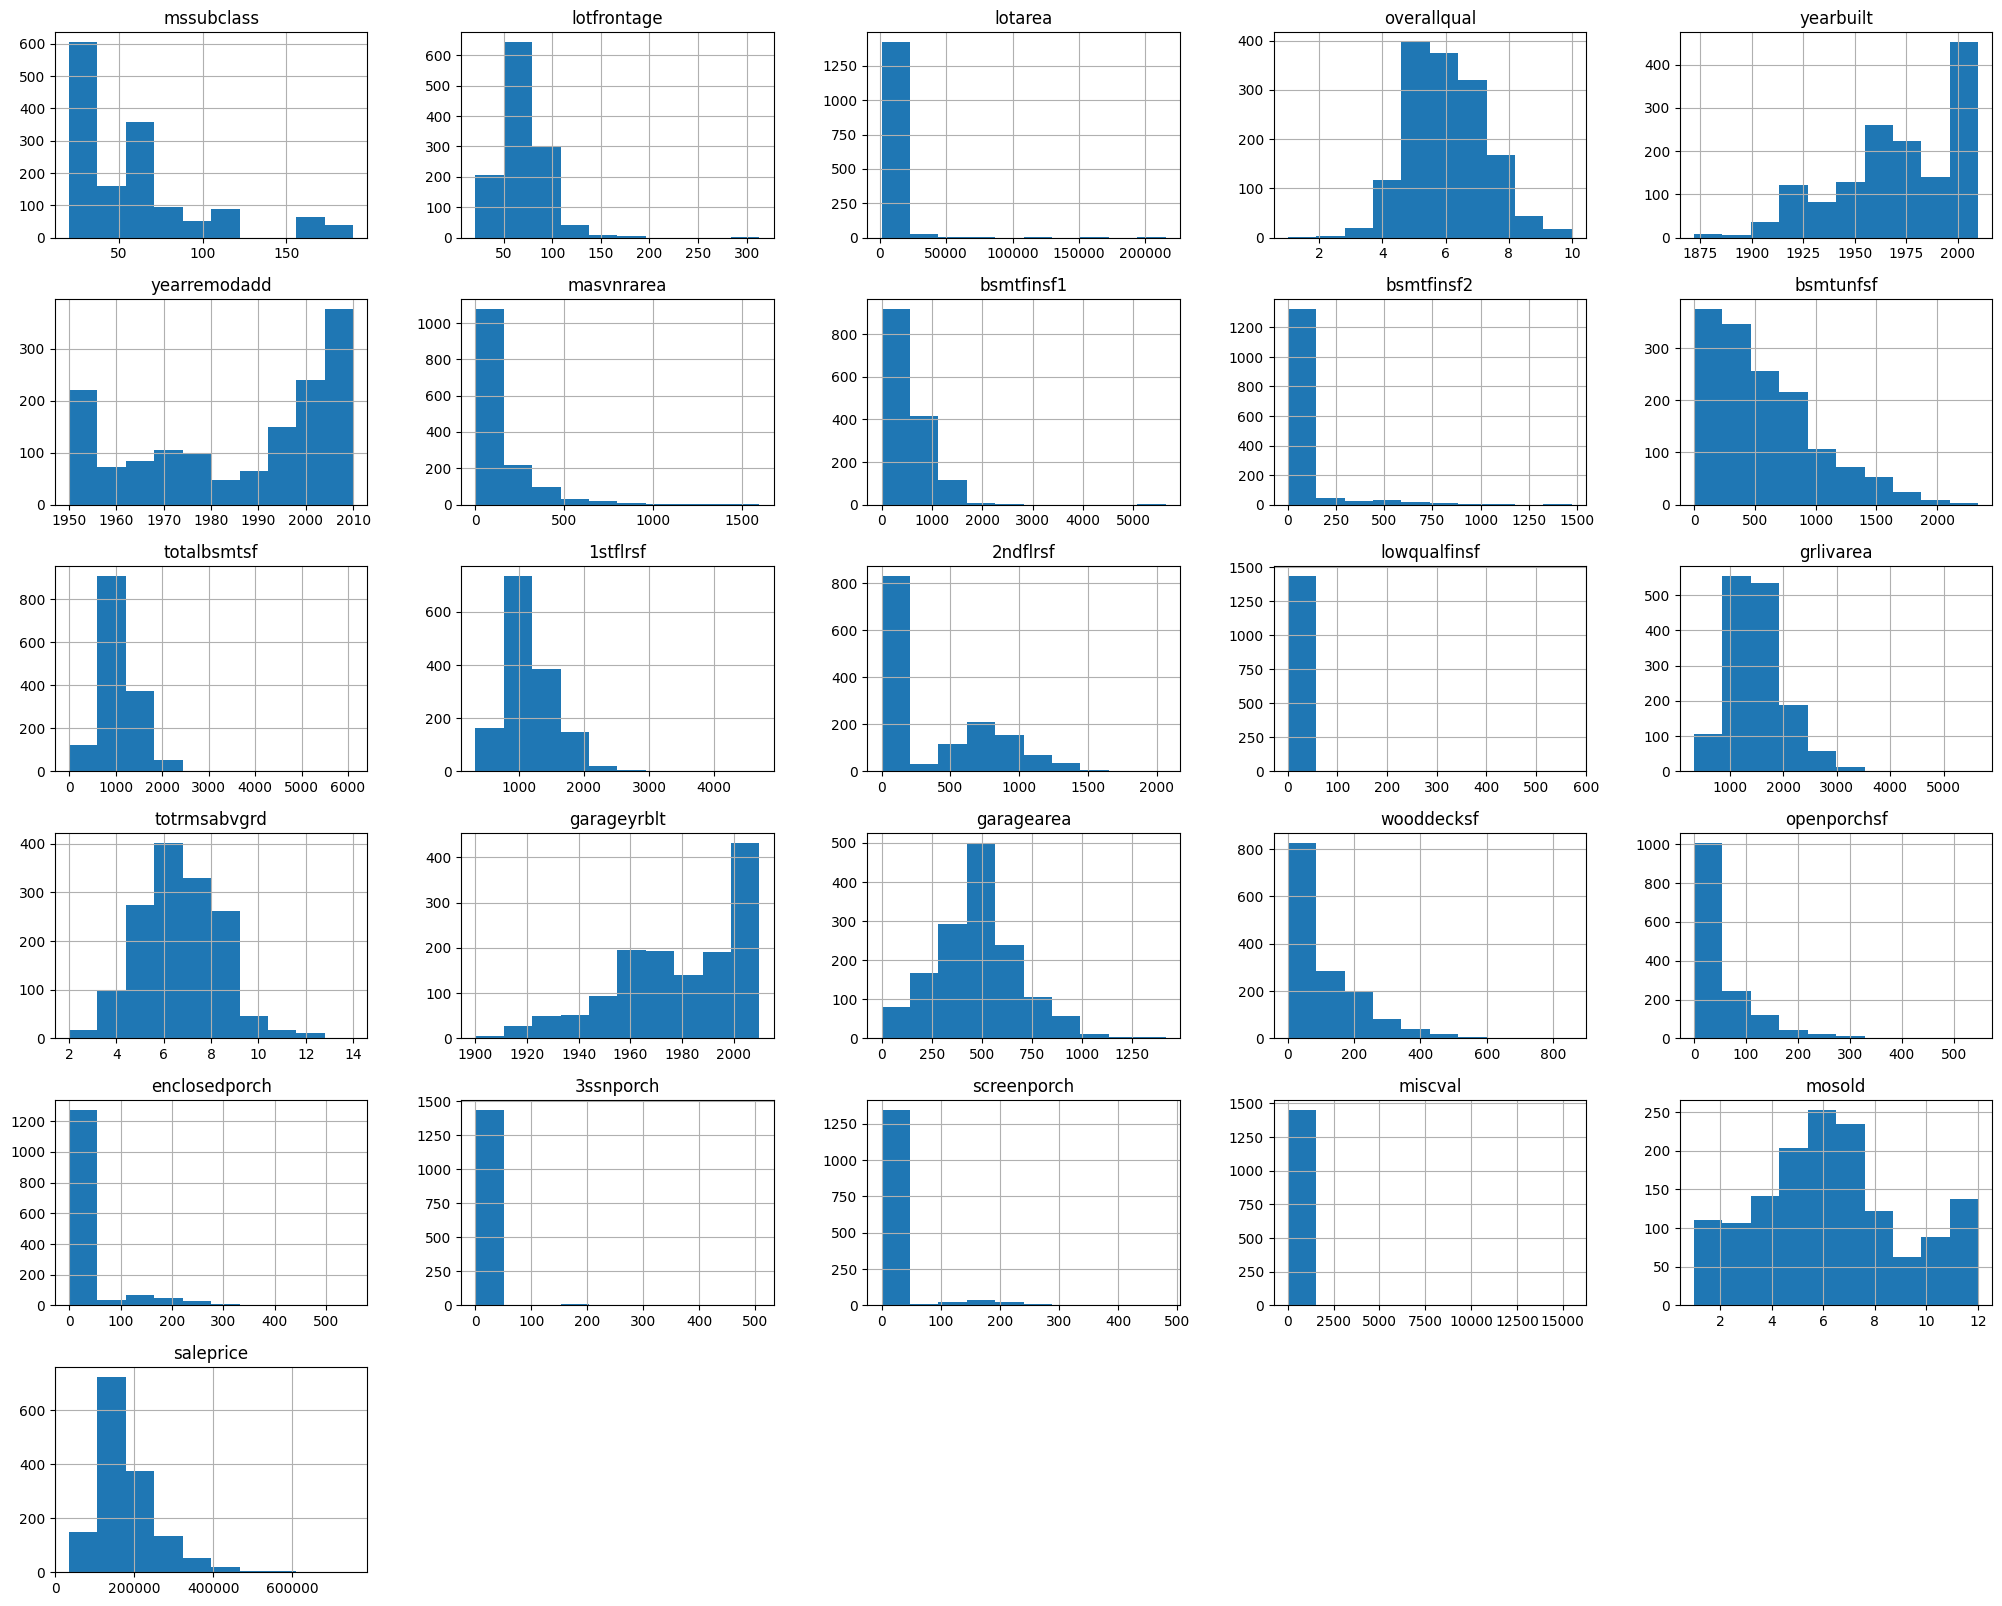

In [52]:
df[num_cols].hist(figsize=(25,20))
plt.show

In [65]:
most_null = []
for i in df.columns:
    null = df[df[i].isnull()]
    if len(null) > 0.3*len(df.index):
        most_null.append(i)
print(most_null)

['alley', 'fireplacequ', 'poolqc', 'fence', 'miscfeature']


In [67]:
df[most_null] = df[most_null].fillna("None")
df[most_null].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   alley        1460 non-null   object
 1   fireplacequ  1460 non-null   object
 2   poolqc       1460 non-null   object
 3   fence        1460 non-null   object
 4   miscfeature  1460 non-null   object
dtypes: object(5)
memory usage: 57.2+ KB


In [87]:
#Replace with none

for col in ('garagetype', 'garagefinish', 'garagequal', 'garagecond'):
        df[col] = df[col].fillna('None')

for col in ('garageyrblt', 'garagearea', 'garagecars'):
        df[col]= df[col].fillna(0)
for col in ('bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf','totalbsmtsf', 'bsmtfullbath', 'bsmthalfbath'):
    df[col] = df[col].fillna(0)

for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
    df[col] = df[col].fillna('None')

df["masvnrtype"] = df["masvnrtype"].fillna("None")
df["masvnrarea"] = df["masvnrarea"].fillna(0)

#Replace missing data with median or mode

df["lotfrontage"] = df.groupby("neighborhood")["lotfrontage"].transform(lambda x: x.fillna(x.median()))

df['mszoning'] = df['mszoning'].fillna(df['mszoning'].mode()[0])
df['electrical'] = df['electrical'].fillna(df['electrical'].mode()[0])
df['kitchenqual'] = df['kitchenqual'].fillna(df['kitchenqual'].mode()[0])
df["functional"] = df["functional"].fillna("Typ")


#Drop variables
df = df.drop(['utilities'], axis=1)

In [90]:
data_na = (df.isnull().sum() / len(df)) * 100
data_na

id               0.0
mssubclass       0.0
mszoning         0.0
lotfrontage      0.0
lotarea          0.0
                ... 
yrsold           0.0
saletype         0.0
salecondition    0.0
saleprice        0.0
lotFrontage      0.0
Length: 81, dtype: float64

In [94]:
all_data_na = (df.isnull().sum() / len(df)) * 100
print(all_data_na.sum())

0.0
